## Library Import

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
from psycopg2 import Error
import os
from dotenv import load_dotenv
import datetime as dt

## SQL Connection Set UP

In [2]:
# Read in ENV credentials 

load_dotenv()

username = os.getenv('USERNAME')
password = os.getenv('PASSWORD')

In [3]:
# Connection to db 
USER = username
PSWD = password
HOST = "pg.analytics.northwestern.edu"
PORT = "5432"
DB_NAME = "everything2023"

# Connect to postgress database
try:
    # Connect to an existing database
    connection = psycopg2.connect(user = USER,
                                  password = PSWD,
                                  host = HOST,
                                  port = PORT,
                                  database = DB_NAME)
    cursor = connection.cursor()
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("You are connected to - ", record, "\n")
    
except (Exception, Error) as error:
    print("Error while connecting to PostgreSQL", error)

You are connected to -  ('PostgreSQL 10.12 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-39), 64-bit',) 



## FEATURE SELECTION

#### get Y label for return rate per store per day (ReturnRate is our y_label)

#### feature 1: number of transactions per store per day

#### feature 2: number of discount sale per day

#### feature 3: amount of money sale per day

#### Ideas of features
#### STATE /location  -- i ma not sure how to use (visualization)
#### SKU properties (price of SKU)  
#### time/year
#### keep brainstorming.....

In [4]:
# Read trnsact table
sql_cmd = """
SELECT 
  "SALEDATE", 
  "STORE", 
  SUM(CASE WHEN "STYPE" = 'R' THEN 1.0 ELSE 0.0 END) / 
  (SUM(CASE WHEN "STYPE" = 'P' THEN 1.0 ELSE 0.0 END) + SUM(CASE WHEN "STYPE" = 'R' THEN 1.0 ELSE 0.0 END)) as "ReturnRate",
  count(*) as "NumTrans",
  SUM(CASE WHEN "SPRICE" < "ORGPRICE" THEN 1 ELSE 0 END) as "DiscountSalesCount",
  SUM("AMT") as "AmtTrans"
  
FROM 
  group_14.trnsact
GROUP BY 
  "SALEDATE", 
  "STORE"
ORDER BY 
  "SALEDATE", 
  "STORE";
"""
return_rate_df = pd.read_sql(sql_cmd, connection);

/var/folders/x7/1lss9g1950lgrxkwhp8c6c180000gn/T/ipykernel_13428/3819196521.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return_rate_df = pd.read_sql(sql_cmd, connection);


In [5]:
return_rate_df

,SALEDATE,STORE,ReturnRate,NumTrans,DiscountSalesCount,AmtTrans
0,2004-08-01,102,0.046968,1171,533,34507.81
1,2004-08-01,103,0.059271,658,349,16873.44
2,2004-08-01,107,0.062332,1492,716,34605.01
3,2004-08-01,202,0.054707,786,420,17108.43
4,2004-08-01,203,0.100752,665,423,16585.97
...,...,...,...,...,...,...
125915,2005-08-27,9704,0.064167,1200,911,20079.25
125916,2005-08-27,9709,0.051787,1371,952,24007.62
125917,2005-08-27,9804,0.056711,1587,1173,29260.54
125918,2005-08-27,9806,0.002625,1143,516,33762.85


In [6]:
## Read in STATE STORE
sql_cmd = """
SELECT "STATE", "STORE"
FROM 
  group_14.strinfo

"""
strinfo = pd.read_sql(sql_cmd, connection);
strinfo.head()

/var/folders/x7/1lss9g1950lgrxkwhp8c6c180000gn/T/ipykernel_13428/3992140737.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  strinfo = pd.read_sql(sql_cmd, connection);


,STATE,STORE
0,FL,2
1,MO,3
2,AR,4
3,TX,7
4,AZ,9


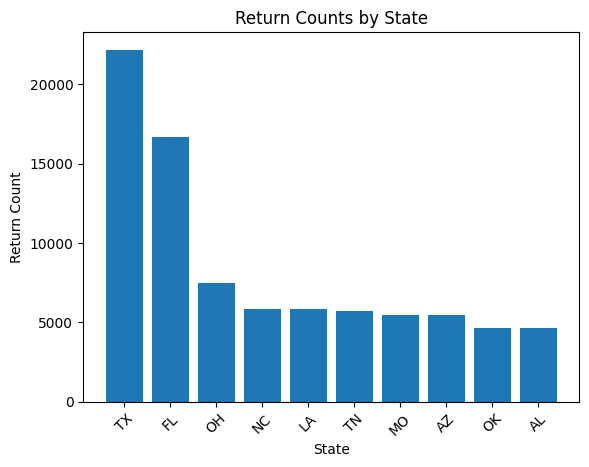

In [7]:
return_states = pd.merge(return_rate_df, strinfo, on="STORE", how='inner')
state_counts = pd.DataFrame(return_states["STATE"].value_counts().head(10)).reset_index()
state_counts.columns = ["STATE", "RETURN_COUNT"]

plt.bar(state_counts["STATE"], state_counts["RETURN_COUNT"])
plt.xlabel("State")
plt.ylabel("Return Count")
plt.title("Return Counts by State")
plt.xticks(rotation=45)
plt.show()

The top 10 states with the most returns 

In [8]:
# Extract different time features 
return_rate_df['Month'] = pd.to_datetime(return_rate_df['SALEDATE']).dt.month
return_rate_df['Quarter'] = pd.to_datetime(return_rate_df['SALEDATE']).dt.quarter
return_rate_df['Day'] = pd.to_datetime(return_rate_df['SALEDATE']).dt.dayofweek
return_rate_df

,SALEDATE,STORE,ReturnRate,NumTrans,DiscountSalesCount,AmtTrans,Month,Quarter,Day
0,2004-08-01,102,0.046968,1171,533,34507.81,8,3,6
1,2004-08-01,103,0.059271,658,349,16873.44,8,3,6
2,2004-08-01,107,0.062332,1492,716,34605.01,8,3,6
3,2004-08-01,202,0.054707,786,420,17108.43,8,3,6
4,2004-08-01,203,0.100752,665,423,16585.97,8,3,6
...,...,...,...,...,...,...,...,...,...
125915,2005-08-27,9704,0.064167,1200,911,20079.25,8,3,5
125916,2005-08-27,9709,0.051787,1371,952,24007.62,8,3,5
125917,2005-08-27,9804,0.056711,1587,1173,29260.54,8,3,5
125918,2005-08-27,9806,0.002625,1143,516,33762.85,8,3,5


In [9]:
return_rate_df = pd.merge(return_rate_df, strinfo, on = "STORE", how = 'inner')
return_rate_df

,SALEDATE,STORE,ReturnRate,NumTrans,DiscountSalesCount,AmtTrans,Month,Quarter,Day,STATE
0,2004-08-01,102,0.046968,1171,533,34507.81,8,3,6,FL
1,2004-08-02,102,0.094268,785,345,19914.37,8,3,0,FL
2,2004-08-03,102,0.109643,757,361,22479.83,8,3,1,FL
3,2004-08-04,102,0.073040,931,500,24991.25,8,3,2,FL
4,2004-08-05,102,0.050680,809,419,26044.38,8,3,3,FL
...,...,...,...,...,...,...,...,...,...,...
125915,2005-08-23,7604,0.124457,691,502,15408.13,8,3,1,VA
125916,2005-08-24,7604,0.077549,1844,1562,32284.12,8,3,2,VA
125917,2005-08-25,7604,0.072272,1439,1186,25298.07,8,3,3,VA
125918,2005-08-26,7604,0.066173,1889,1546,35247.64,8,3,4,VA


In [12]:
# JOIN skstinfo and skuinfo to get cost of sku 
sql_cmd = """
SELECT sku."SKU", sks."Cost"
FROM group_14.skstinfo sks
JOIN group_14.skuinfo sku on sku."SKU" = sks."SKU"
"""
skstinfo = pd.read_sql(sql_cmd, connection);
skstinfo.head()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,SKU,Cost
0,1918,15.00
1,3986,26.85
2,3986,26.85
3,3986,26.85
4,3986,26.85


In [21]:
# Use SKU and Store info to calcualte return rate
sql_cmd = """
SELECT "SKU", 
SUM(CASE WHEN "STYPE" = 'R' THEN 1.0 ELSE 0.0 END) / 
	(SUM(CASE WHEN "STYPE" = 'P' THEN 1.0 ELSE 0.0 END) + SUM(CASE WHEN "STYPE" = 'R' THEN 1.0 ELSE 0.0 END)) as "ReturnRate"
FROM group_14.trnsact
GROUP BY "SKU"
ORDER BY "SKU"
"""
sku_return_rate = pd.read_sql(sql_cmd, connection);

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


KeyboardInterrupt: 

In [22]:
sku_return_rate.head(20)

,SKU,ReturnRate
0,3,0.200000
1,4,0.103448
2,5,0.090909
3,8,0.142857
4,20,0.000000
5,23,0.166667
6,24,0.034483
7,50,1.000000
8,55,0.000000
9,65,0.000000


## Data Visualization

In [13]:
## how return rate for store 102 working in times series
def plot_return_for_store(store_num):
    # Filter the DataFrame for store 102
    store_data = return_rate_df[return_rate_df['STORE'] == store_num]
    
    # Ensure SaleDate is a datetime type for proper plotting
    store_data['SALEDATE'] = pd.to_datetime(store_data['SALEDATE'])
    
    # Plotting
    plt.figure(figsize=(10, 5))  # You can adjust the figure size as needed
    plt.plot(store_data['SALEDATE'], store_data['ReturnRate'], marker='o')
    
    plt.title(f'Return Rate Over Time for Store {store_num}')
    plt.xlabel('Sale Date')
    plt.ylabel('Return Rate')
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
    plt.tight_layout()  # Adjusts plot parameters to give the plot more room
    
    # Display the plot
    plt.show()

/var/folders/fr/1bq79xyx0qdfkw303z4l6mf40000gn/T/ipykernel_1331/3275164606.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_data['SALEDATE'] = pd.to_datetime(store_data['SALEDATE'])


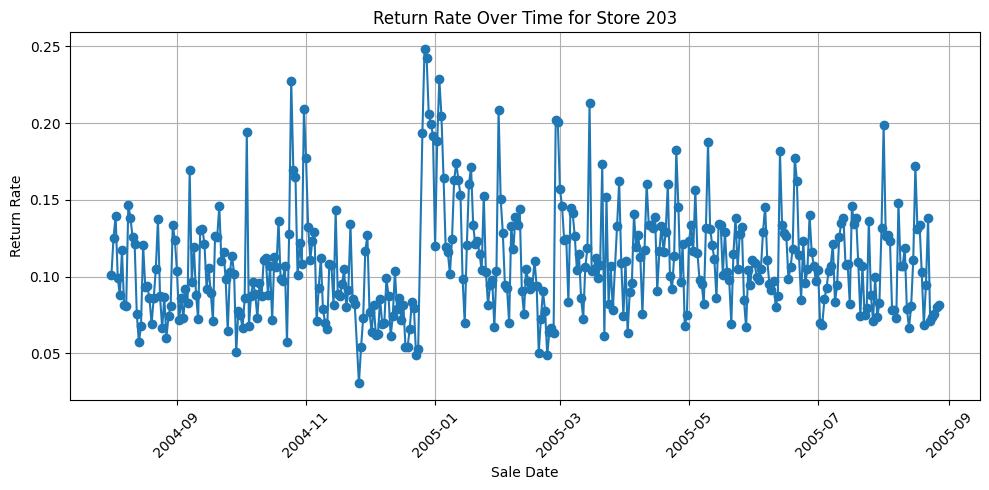

In [14]:
plot_return_for_store(203)